# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')


In [2]:
import pickle
from simulation import MultiTODSimulation
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:
# Make all the individual variables available for backward compatibility
t_list = multi_tod_sim.t_list
theta_c_setting = multi_tod_sim.theta_c_setting
phi_c_setting = multi_tod_sim.phi_c_setting
theta_c_rising = multi_tod_sim.theta_c_rising
phi_c_rising = multi_tod_sim.phi_c_rising
bool_map_setting = multi_tod_sim.bool_map_setting
bool_map_rising = multi_tod_sim.bool_map_rising
integrated_beam_setting = multi_tod_sim.integrated_beam_setting
integrated_beam_rising = multi_tod_sim.integrated_beam_rising
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
integrated_beam = multi_tod_sim.integrated_beam
Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising
sky_params = multi_tod_sim.sky_params
ntime = multi_tod_sim.ntime
ndiode_proj = multi_tod_sim.ndiode_proj
nd_rec_operator = multi_tod_sim.nd_rec_operator
nd_rec_params = multi_tod_sim.nd_rec_params
gain_proj = multi_tod_sim.gain_proj
gain_params_setting = multi_tod_sim.gain_params_setting
gain_params_rising = multi_tod_sim.gain_params_rising
gains_setting = multi_tod_sim.gains_setting
gains_rising = multi_tod_sim.gains_rising
fc = multi_tod_sim.fc
logfc = multi_tod_sim.logfc
f0 = multi_tod_sim.f0
logf0 = multi_tod_sim.logf0
noise_setting = multi_tod_sim.noise_setting
noise_rising = multi_tod_sim.noise_rising
Tsys_setting = multi_tod_sim.Tsys_setting
Tsys_rising = multi_tod_sim.Tsys_rising
TOD_setting = multi_tod_sim.TOD_setting
TOD_rising = multi_tod_sim.TOD_rising
pixels_c_setting = multi_tod_sim.pixels_c_setting
bool_map_c_setting = multi_tod_sim.bool_map_c_setting
calibration_1_index = multi_tod_sim.calibration_1_index
calibration_5_indices = multi_tod_sim.calibration_5_indices

# Additional constants from the original code
T_ndiode = multi_tod_sim.T_ndiode
rec_params = multi_tod_sim.rec_params
dtime = multi_tod_sim.dtime
alpha = multi_tod_sim.alpha
logf0_list = [multi_tod_sim.logf0]
sigma_2 = multi_tod_sim.sigma_2

In [4]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [logf0, alpha]


init_Tloc_params_list = [nd_rec_params, nd_rec_params]
init_Tsky_params = sky_params
init_noise_params_list = [init_noise_params, init_noise_params]

prior_std_frac = 0.1

# gain_prior_mean = gain_params_setting
# gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
# gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100

Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
calibration_indices = calibration_1_index
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 1.0
aux[1] = 1.0
Trec_prior_cov_inv_list = [aux, aux]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [5]:
gain_prior_mean_setting = gain_params_setting
gain_prior_mean_rising = gain_params_rising

gain_prior_cov_inv_setting = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv_setting[gain_prior_cov_inv_setting > 100] = 100
gain_prior_cov_inv_rising = 1.0 / (prior_std_frac * gain_params_rising)**2  # Prior STD ~10%
gain_prior_cov_inv_rising[gain_prior_cov_inv_rising > 100] = 100

In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples = \
    TOD_Gibbs_sampler(
        [TOD_setting, TOD_rising],
        [t_list, t_list],
        [gain_proj, gain_proj],
        [Tsky_operator_setting, Tsky_operator_rising],
        [nd_rec_operator, nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc, logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params, nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv_setting, gain_prior_cov_inv_rising],
        local_gain_prior_mean_list=[gain_prior_mean_setting, gain_prior_mean_rising],
        local_noise_prior_func_list=[None, None],
        joint_Tsys_sampling=True,
        smooth_gain_model="linear",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20)

In [ ]:
# First, save the samples as npy files..

np.save("outputs/GS1_db/Tsys_samples_linearG.npy", Tsys_samples)
np.save("outputs/GS1_db/gain_samples_linearG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1_db/noise_samples_linearG.npy", np.concatenate(all_noise_samples, axis=0))


In [6]:
Tsys_samples = np.load("outputs/GS1_db/Tsys_samples_linearG.npy")
gain_samples = np.load("outputs/GS1_db/gain_samples_linearG.npy")
noise_samples = np.load("outputs/GS1_db/noise_samples_linearG.npy")


In [5]:
from MCMC_diagnostics import diagnostics

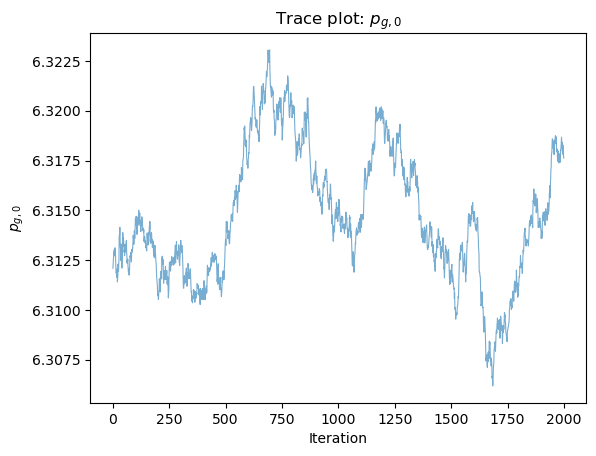

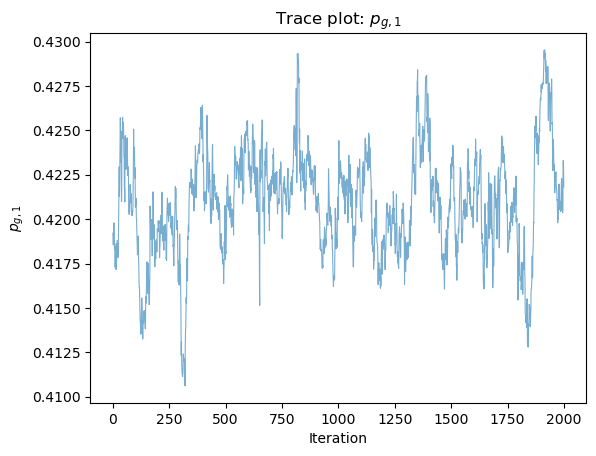

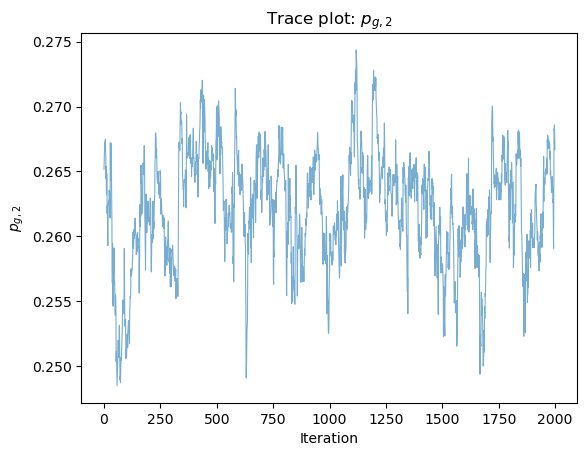

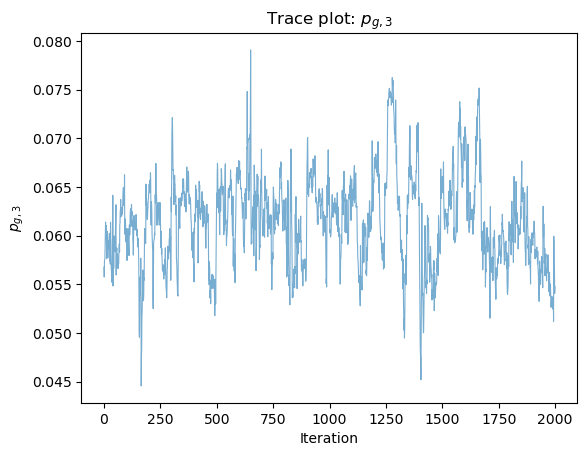

{'$p_{g,0}$': {'ESS_min': 8.230058379317423,
  'ESS_median': 8.230058379317423,
  'Rhat_split': 1.0260918513400366},
 '$p_{g,1}$': {'ESS_min': 41.82836547561471,
  'ESS_median': 41.82836547561471,
  'Rhat_split': 1.0016114401927847},
 '$p_{g,2}$': {'ESS_min': 36.7701337691864,
  'ESS_median': 36.7701337691864,
  'Rhat_split': 0.9996808487151433},
 '$p_{g,3}$': {'ESS_min': 57.57551298980581,
  'ESS_median': 57.57551298980581,
  'Rhat_split': 0.9996509938959403}}

In [6]:
aux = gain_samples[0].reshape(1, 2000, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

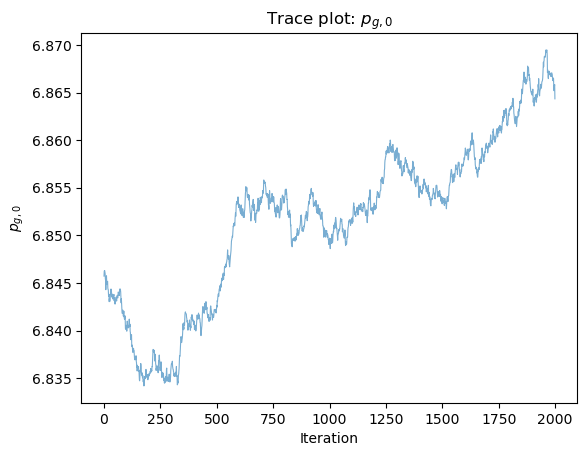

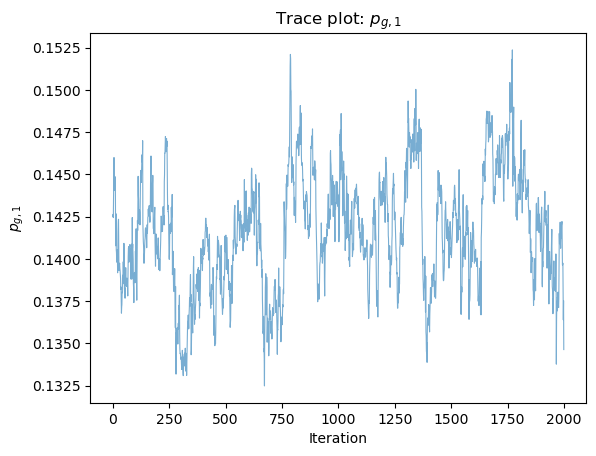

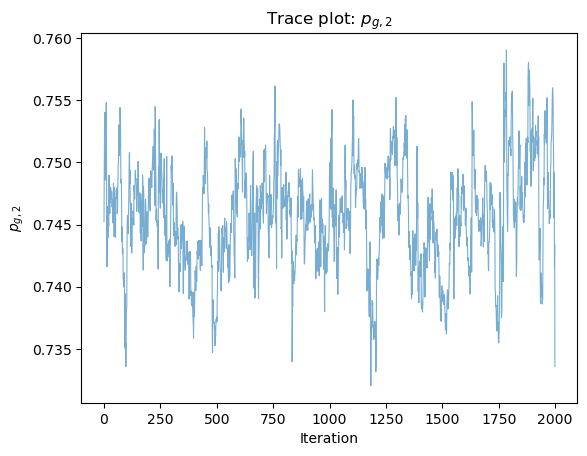

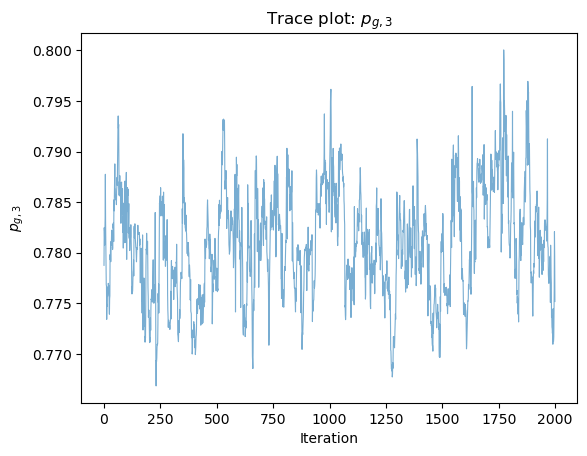

{'$p_{g,0}$': {'ESS_min': 3.416011241749522,
  'ESS_median': 3.416011241749522,
  'Rhat_split': 1.7665617643805043},
 '$p_{g,1}$': {'ESS_min': 33.03015086808548,
  'ESS_median': 33.03015086808548,
  'Rhat_split': 1.068856009068982},
 '$p_{g,2}$': {'ESS_min': 67.74824813777208,
  'ESS_median': 67.74824813777208,
  'Rhat_split': 1.0039482303921057},
 '$p_{g,3}$': {'ESS_min': 45.11685265931596,
  'ESS_median': 45.11685265931596,
  'Rhat_split': 1.0112184462148974}}

In [7]:
# Gain parameters of the second TOD
aux = gain_samples[1].reshape(1, 2000, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

292
All pixels - Mean: -0.0268, Std: 0.2966, RMS: 0.2978
All pixels - 16th-84th percentile: [-0.0531, 0.0695]
Internal pixels - Mean: -0.0093, Std: 0.1981, RMS: 0.1983
Internal pixels - 16th-84th percentile: [-0.0339, 0.0186]
Plot saved to: figures/new/GS1_db_mean_res.pdf


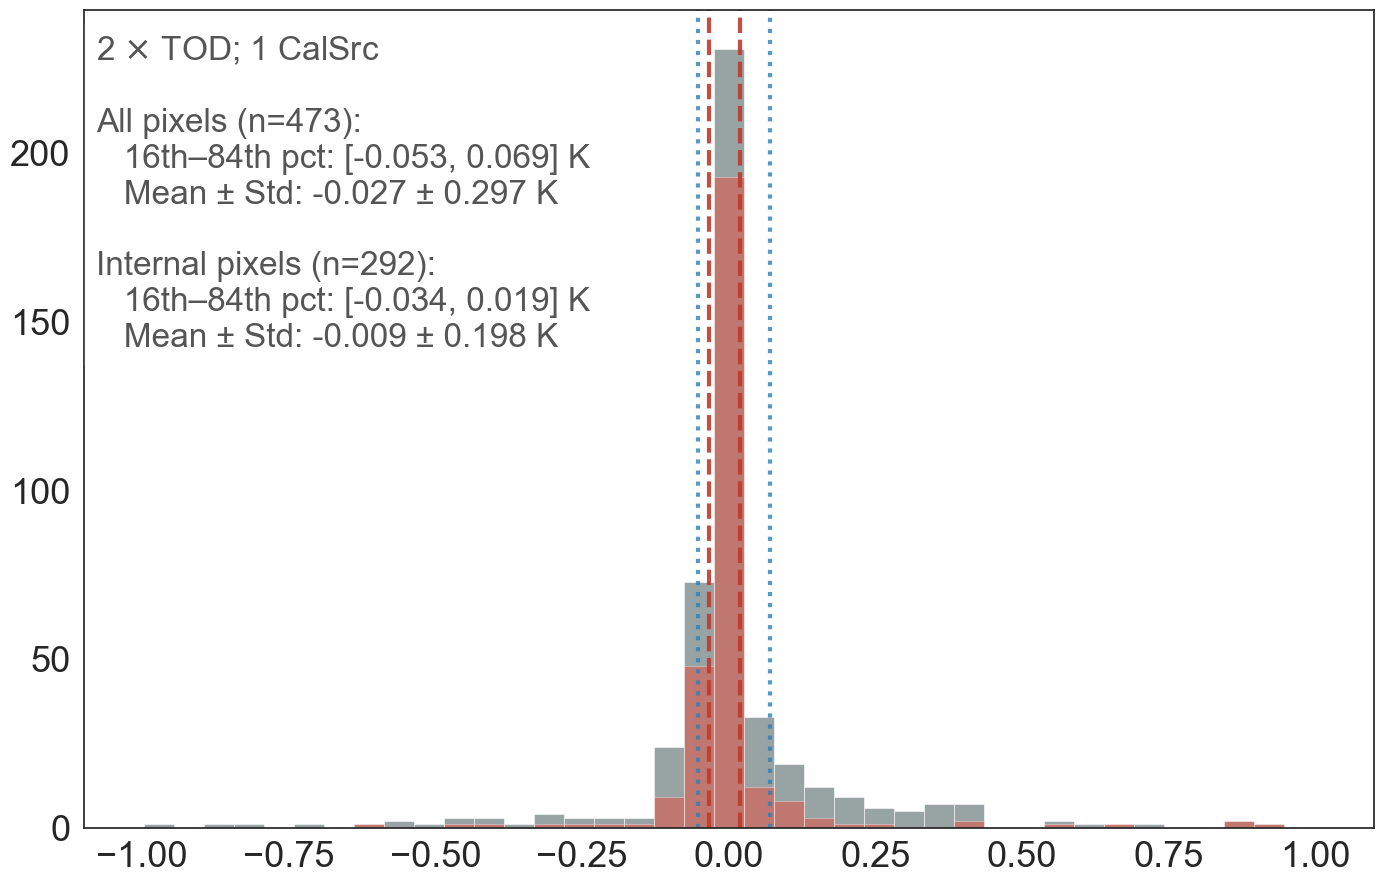

All pixels - Mean: -0.0273, Std: 0.2994, RMS: 0.3006
All pixels - 16th-84th percentile: [-0.0507, 0.0653]
Internal pixels - Mean: -0.0095, Std: 0.1985, RMS: 0.1987
Internal pixels - 16th-84th percentile: [-0.0342, 0.0188]
Plot saved to: figures/new/GS1_db_median_res.pdf


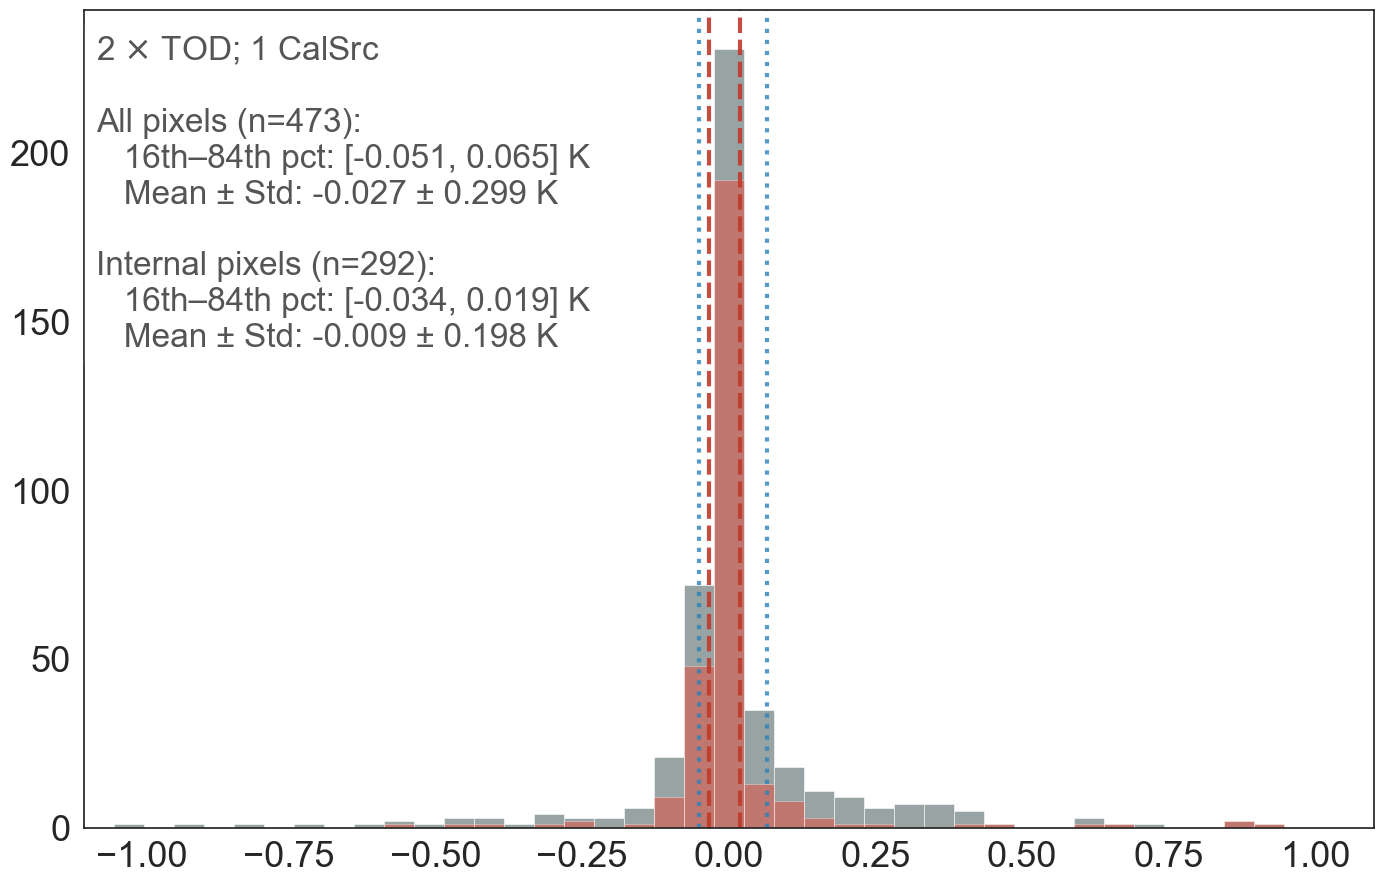

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 8.51547286,  8.38327411,  8.47199975,  8.19861142,  8.06897341,
          7.90417764,  7.61619509,  7.31341064,  7.83898516,  6.99288233,
          8.4009279 ,  8.18140042,  8.81255736,  8.52422653,  8.93878372,
          8.11730367,  7.76349127,  8.72471469,  8.71637828,  7.8066095 ,
          8.23677316,  8.02448287,  8.82853861,  7.043033  ,  7.31516946,
          7.11650385,  6.7954645 ,  7.72011147,  6.27943648,  6.141848  ,
          6.31872657,  6.00003515,  5.00041383,  5.75810303,  5.66502908,
          5.78988418,  5.84185327,  8.64498983,  8.82559251,  8.63643564,
          8.56476908,  8.34602835,  8.89733471,  8.09475018,  7.86190179,
          7.84837256,  7.81041678,  8.0835506 ,  7.83868669,  7.61858398,
          6.89148699,  6.70821215,  6.97857051,  6.7396599 ,  6.43472536,
          6.32756513,  6.21974084,  6.07396902,  5.63311578,  5.92998388,
          5.52481527,  5.71527132,  6.00918135,  6.09471553,  8.47044955,
          9.26817689,  8.89324

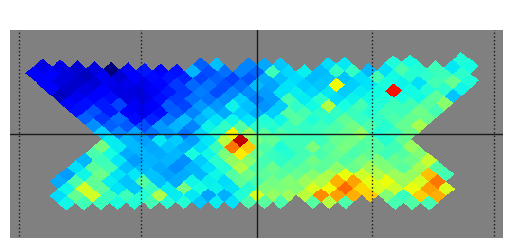

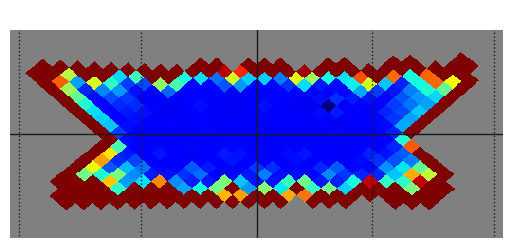

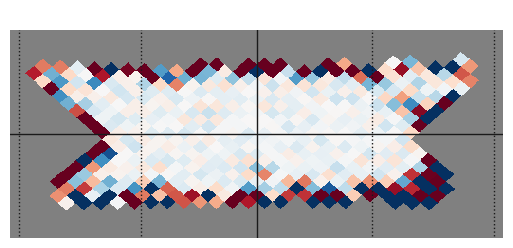

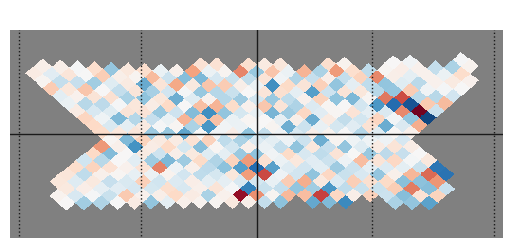

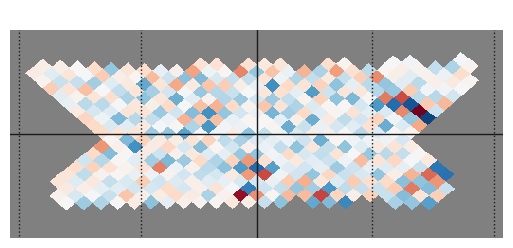

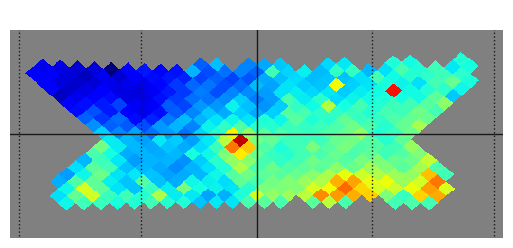

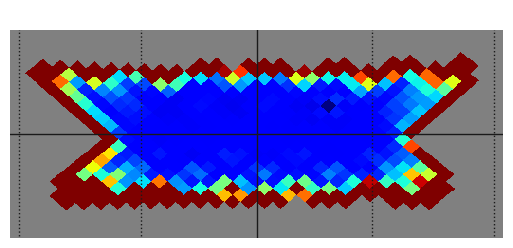

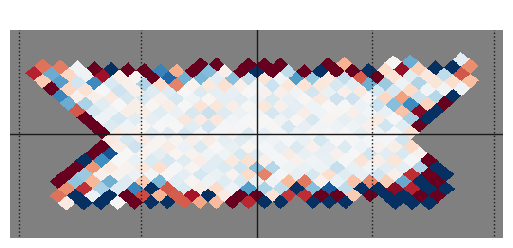

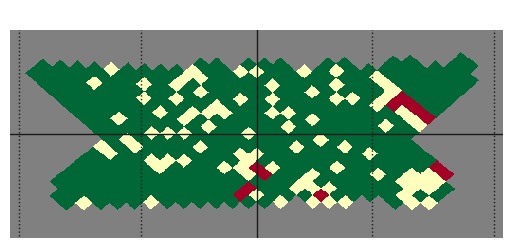

In [7]:
from simulation import TODSimulation, MultiTODSimulation

from analysis import explore_posterior_joint_Tsys

explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'2 $\times$ TOD; 1 CalSrc',
                             save_path='figures/new/GS1_db',
                             two_x_TODs=True, 
                             warm_up=0, 
                             cbar=False
                             )